In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess dataset
file_path = 'SAN.MC.csv'
df_SAN = pd.read_csv(file_path)
df_SAN = df_SAN.interpolate(method='linear', limit_direction='both', axis=0)
df_SAN['Date'] = pd.to_datetime(df_SAN['Date'])
df_SAN.set_index('Date', inplace=True)


In [2]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [3]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_close_SAN = df_SAN['Close'].values.reshape(-1, 1)
scaled_df_close_SAN = scaler.fit_transform(df_close_SAN)


In [4]:
# Split the data into training and testing datasets
train_size_SAN = int(len(scaled_df_close_SAN) * 0.8)
train_SAN, test_SAN = scaled_df_close_SAN[:train_size_SAN], scaled_df_close_SAN[train_size_SAN:]


In [5]:
# Create training and testing datasets
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX_SAN, trainY_SAN = create_dataset(train_SAN, look_back)
testX_SAN, testY_SAN = create_dataset(test_SAN, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX_SAN, (trainX_SAN.shape[0], 1, trainX_SAN.shape[1]))
testX = np.reshape(testX_SAN, (testX_SAN.shape[0], 1, testX_SAN.shape[1]))


In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

# Function to create Keras model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters to search
units_options = np.arange(4, 44, 10)
epochs_options = [100, 150]

best_score = float('inf')
best_params = {}

for units in units_options:
    for epochs in epochs_options:
        tf.keras.backend.clear_session()
        model = create_model(units)
        model.fit(trainX, trainY_SAN, epochs=epochs, batch_size=1, verbose=0)

        predictions = model.predict(testX).flatten()
        mse = mean_squared_error(testY_SAN, predictions)

        if mse < best_score:
            best_score = mse
            best_params = {'units': units, 'epochs': epochs}

print("Best Model: MSE = %f using %s" % (best_score, best_params))


16/16 [==============================] - 0s 2ms/step
Best Model: MSE = 0.000111 using {'units': 34, 'epochs': 150}


In [7]:
# Recreate the best model using the identified parameters
model_best = create_model(best_params['units'])
model_best.fit(trainX, trainY_SAN, epochs=best_params['epochs'], batch_size=1, verbose=1)



Epoch 1/150
2046/2046 [==============================] - 7s 3ms/step - loss: 0.0133
Epoch 2/150
2046/2046 [==============================] - 4s 2ms/step - loss: 2.7387e-04
Epoch 3/150
2046/2046 [==============================] - 4s 2ms/step - loss: 2.5551e-04
Epoch 4/150
2046/2046 [==============================] - 6s 3ms/step - loss: 2.5312e-04
Epoch 5/150
2046/2046 [==============================] - 4s 2ms/step - loss: 2.5861e-04
Epoch 6/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.4951e-04
Epoch 7/150
2046/2046 [==============================] - 5s 3ms/step - loss: 2.4718e-04
Epoch 8/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.4816e-04
Epoch 9/150
2046/2046 [==============================] - 6s 3ms/step - loss: 2.5378e-04
Epoch 10/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.4923e-04
Epoch 11/150
2046/2046 [==============================] - 4s 2ms/step - loss: 2.4876e-04
Epoch 12/150
2046/2046 [==========

In [8]:
# Make predictions on the test dataset
testPredictions = model_best.predict(testX).flatten()

# Invert predictions to original scale
testPredictions_original = scaler.inverse_transform(testPredictions.reshape(-1, 1)).flatten()
testY_original = scaler.inverse_transform(testY_SAN.reshape(-1, 1)).flatten()


16/16 [==============================] - 0s 3ms/step


In [9]:
# Calculate performance metrics on the original scale
mse_original = mean_squared_error(testY_original, testPredictions_original)
rmse_original = np.sqrt(mse_original)
mape_original = np.mean(np.abs((testY_original - testPredictions_original) / testY_original)) * 100

print(f'Mean Squared Error (MSE) on Original Scale: {mse_original}')
print(f'Root Mean Squared Error (RMSE) on Original Scale: {rmse_original}')
print(f'Mean Absolute Percentage Error (MAPE) on Original Scale: {mape_original}%')


Mean Squared Error (MSE) on Original Scale: 0.003955047583963188
Root Mean Squared Error (RMSE) on Original Scale: 0.06288916905130158
Mean Absolute Percentage Error (MAPE) on Original Scale: 1.52990893956591%


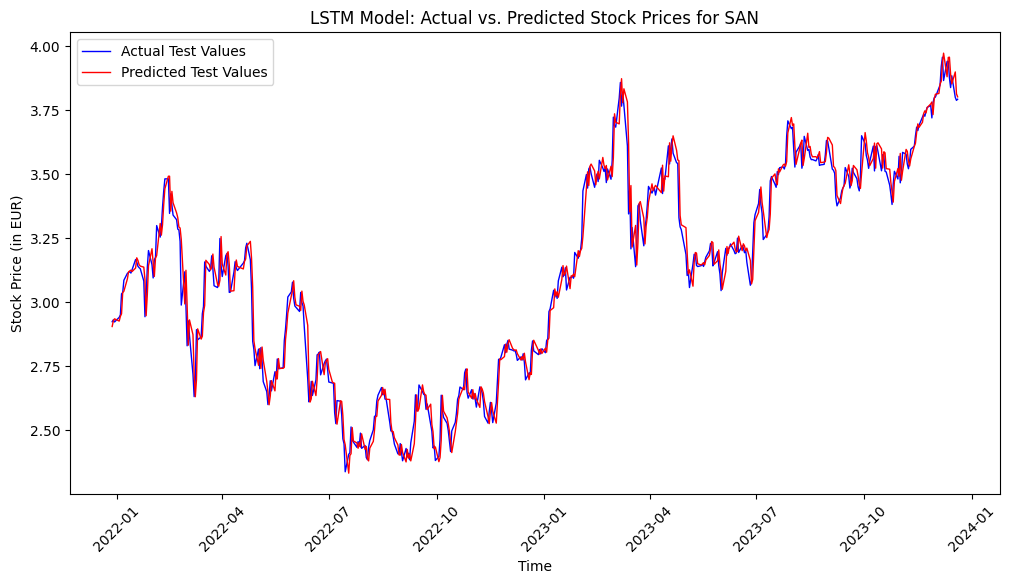

In [10]:
import matplotlib.pyplot as plt

# Plotting the final model predictions
plt.figure(figsize=(12,6))
plt.plot(df_SAN.index[train_size_SAN + look_back + 1:len(df_SAN)], testY_original, label='Actual Test Values', color='blue', linewidth=1)
plt.plot(df_SAN.index[train_size_SAN + look_back + 1:len(df_SAN)], testPredictions_original, label='Predicted Test Values', color='red', linewidth=1)
plt.title('LSTM Model: Actual vs. Predicted Stock Prices for SAN')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.xticks(rotation=45)
plt.show()
